In [ ]:
from scipy import sparse
import numpy as np
import itertools
import copy

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import gaussian_kde
from tqdm import tqdm_notebook
from seaborn import kdeplot

In [ ]:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
#interaction_matrix = np.array(interaction_matrix.todense())

interaction_dates = sparse.load_npz('../data/interaction_dates_pchembl.npz')
#interaction_dates = np.array(interaction_dates.todense())

The publication dates of the interactions are recorded in ChEMBL. Looking below we can see the distribution of years: 

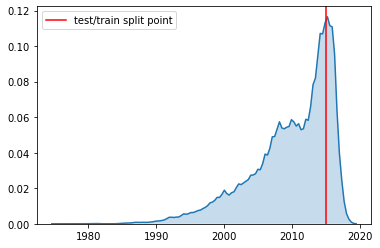

In [3]:
#removing 'year=1' which were originally NaNs in ChEMBL:
_ = kdeplot(interaction_dates.data[interaction_dates.data>1950], shade=True)
#bonus - set 'cumulative=True' in kdeplot to visualize the amount of data that will be in the test set.
plt.axvline(2015, c='red', label='test/train split point')
plt.legend()

These can thus be used to perform time-split cross validation, which simulates prospective validation. The below sets a year, and creates a training matrix with all interactions equal to or before that year, and a test matrix with all interactions from after that year. 

In [4]:
year = 2015

#turn interaction dates into a masker
interaction_dates.data = (interaction_dates.data<=year).astype(int)

#make copies that will become train / test matrices
train = copy.copy(interaction_matrix)
test = copy.copy(interaction_matrix)

#remove 2015 and later records from train matrix
train.data = train.data * interaction_dates.data
#remove all training data from the test matrix. 
test.data = test.data - train.data

#remove any rows from the train matrix that have zero interactions.
#this is the case any time a new ligand is discovered in 2015 or after. 
#we can't use link prediction on new ligands! It's a cold start problem. 
#so we remove all these ligands from the present analysis. 
row_mask = np.array((train.sum(axis=1)!=0)).reshape(1,-1)[0] #there must be a cleaner way to do that.
train = train[row_mask] 
test = test[row_mask]

Make a pairwise correlation graph from the training matrix:

In [250]:
##This version uses sparse matrices, which keeps everything low
##memory. But it's a bit slower because getting/setting sparse objects is in general
##slower than numpy. 
def makeCorrelations(y_in):
    assert isinstance(y_in, sparse.csr_matrix)
    tot_instances = np.array(y_in.sum(axis=0))[0]
    L = sparse.lil_matrix((y_in.shape[1], y_in.shape[1]))

    for idx in tqdm_notebook(range(y_in.shape[0]), smoothing=0.1):
        row = y_in[idx]
        if row.sum()>1:
            for j,k in itertools.permutations(row.nonzero()[1], 2):
                L[j,k] += (1)/(tot_instances[k])             
    return L

##This calculates predicted probabilities for labels (1's in the train matrix are preserved as 1's)
def makePredictions(y_in, L):
    L1 = 1-L.toarray() #working with dense array is much easier for this. 
                    #but because it's only numLabels x numLabels it's not that big.
    y_new = y_in.toarray().astype('float32') #working with a dense array again
                                             #for ease of row-wise, elementwise addition 
    for count, row in tqdm_notebook(enumerate(y_in), total=y_in.shape[0], smoothing=0.1):
        posLines = row.nonzero()[1]
        corrs = L1[:,posLines]
        probs = 1-np.prod(corrs, axis=1)
        y_new[count]+=probs #elementwise addition here. 
        y_new[count] = np.clip(y_new[count], 0, 1)
    return sparse.csr_matrix(y_new)

In [251]:
#L = makeCorrelations(train)
y_new = makePredictions(train, L)

In [ ]:
import lightfm

In [287]:
##lightfm requires a particular way of getting the predictions:
#lightfm 'user id' (chemical id)
cid = np.arange(train.shape[0])
#lightfm 'item id' (target id)
tid = np.arange(train.shape[1])

model = lightfm.LightFM(no_components = 127,
                           loss='warp',
                           max_sampled=9,
                           learning_rate=0.0561)
model.fit(train, epochs=6)

pred_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
pred_matrix = np.reshape(pred_matrix, (len(cid), len(tid)))

In [311]:
train2 = train.T

##lightfm requires a particular way of getting the predictions:
#lightfm 'user id' (chemical id)
cid = np.arange(train2.shape[0])
#lightfm 'item id' (target id)
tid = np.arange(train2.shape[1])

model = lightfm.LightFM(no_components = 127,
                           loss='warp',
                           max_sampled=9,
                           learning_rate=0.0561)
model.fit(train2, epochs=6)

pred_matrix2 = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
pred_matrix2 = np.reshape(pred_matrix2, (len(cid), len(tid)))

In [324]:
#order from highest to lowest:
order = (-pred_matrix.T).argsort(axis=1)
#get ranks of each ligand.
ranks = order.argsort(axis=1)

In [312]:
#order from highest to lowest:
order2 = (-pred_matrix2).argsort(axis=1)
#get ranks of each ligand.
ranks2 = order2.argsort(axis=1)

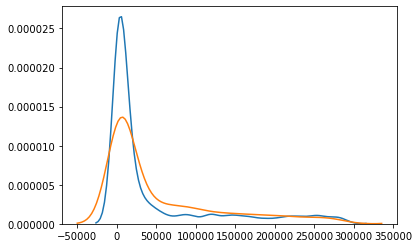

In [310]:
kdeplot(ranks[test.T])
kdeplot(ranks2[test.T])

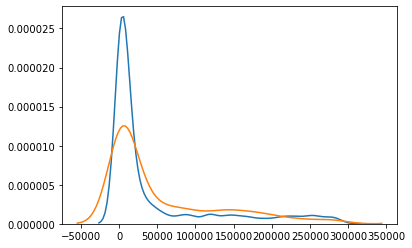

In [313]:
kdeplot(ranks[test.T])
kdeplot(ranks2[test.T])

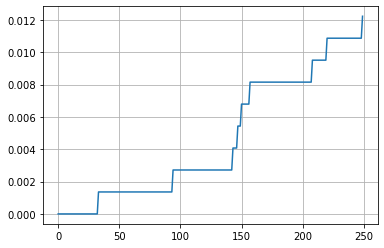

In [327]:
test_ranks = ranks[test.T]
branks = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 250)]
plt.plot(branks)
plt.grid()

In [323]:
ranks

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
#order from highest to lowest:
order2 = (-pred_matrix2).argsort(axis=1)
#get ranks of each ligand.
ranks2 = order2.argsort(axis=1)

In [295]:
#order from highest to lowest:
order2 = (-pred_matrix2).argsort(axis=1)
#get ranks of each ligand.
ranks2 = order2.argsort(axis=1)

In [296]:
order

array([[126, 123, 129, ..., 169, 162, 220],
       [ 93, 174,  15, ..., 161,  32,   8],
       [122,  88, 116, ..., 198, 212,  45],
       ...,
       [145, 172, 203, ..., 103,  93,  19],
       [179, 169, 170, ...,  15,  93,  20],
       [ 96,  52, 127, ..., 118,  81,  30]])

In [297]:
order2.T

array([[279793, 100963, 164189, ..., 205439, 221063, 133153],
       [ 57717, 160445, 150823, ..., 140330,  86155, 108095],
       [255076, 160804, 159621, ..., 208037, 264811, 141879],
       ...,
       [136866,  66739,   1659, ...,  30147, 233293, 286272],
       [ 40915, 271701,  71601, ..., 119870, 256637,  66142],
       [173943,  15068, 179817, ..., 118786, 115177,  66796]])

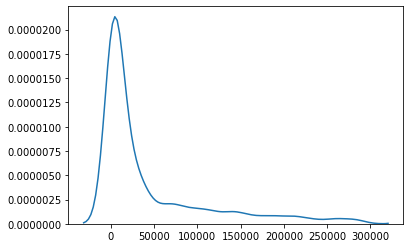

In [298]:
kdeplot(ranks2[test.T])

In [301]:
from lightfm import LightFM, datasets
data = datasets.fetch_movielens()


In [303]:
data['train']

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>

In [300]:
ranks2[test.T]

array([ 63803, 111010, 257660, 213878, 160934, 258266, 281398,  22966,
       208564, 250463,  95300, 115554,  82144, 116349,  46719, 232460,
       104934, 187456,   4122,    818,   2632,   2348,   3550,   1419,
          539, 175753, 225595,   5530,   7043,  38435,   2862,  69492,
       148256,   8045,   2082,   9229,     98,   1110,   1902,    436,
          905,   2355,  15723,   1654,   1431,   8934,   1767,    577,
         7319, 139400,  12150, 141921,    117,  51132,   1955,   2059,
         2864,  19702,   3924,   8331,   5312,   3452,   4864,   2553,
         8908,  10821,   2011,   5645,   9563,   9384,  17813,   4722,
        10186,  19543,  15306,   2834,   6225,   3543,   3711,   5430,
         3828,  33044,   9080,   4378,   4575,  15418,  37016,  63702,
          951,   6930,    481,  19857,   9428,   3226,  20903,  13035,
        19693,   7067,   2715, 268340,  16911,  15207,  67698,     40,
          386, 169317,   4066,    840,     46,   6117,   9924,  11785,
      

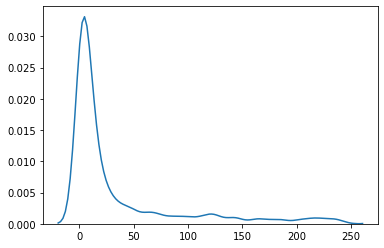

In [293]:
kdeplot(ranks[test])

In [ ]:
##new version, reporting the average rank of test ligands.
#order from highest to lowest:
order = (-prediction_matrix).argsort()
#get ranks of each ligand. 
ranks = order.argsort()
    
#calc rank fo each ligand
#test2 = np.array(test.todense())
test_ranks = ranks[row_mask][np.array(test[row_mask], dtype=bool)]

plt.plot(test_ranks, linewidth=0.1)

In [ ]:
ranks = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot(ranks)
plt.grid()

In [ ]:
import lightfm
##LightFM:                                                                                                                                                                     
#lightfm 'user id' (chemical id)                                                                                                                                               
cid = np.arange(train.shape[0])
#lightfm 'item id' (target id)                                                                                                                                                 
tid = np.arange(train.shape[1])
model = lightfm.LightFM(no_components = 127,
                           loss='warp',
                           max_sampled=9,
                           learning_rate=0.056129688436596194)
model.fit(sparse.csr_matrix(train), epochs=6)
lfm_prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
lfm_prediction_matrix = np.reshape(lfm_prediction_matrix, (len(cid), len(tid)))


In [ ]:
order_lc = (-lc_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_lc = order_lc.argsort()

order_im = (-im_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_im = order_im.argsort()

order_lfm = (-lfm_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_lfm = order_lfm.argsort()

In [ ]:
inverse_ranks_lc = 1/(order_lc.argsort()+1)
inverse_ranks_im = 1/(order_im.argsort()+1)
inverse_ranks_lfm = 1/(order_lfm.argsort()+1)

In [ ]:
inverse_combined = inverse_ranks_lc+inverse_ranks_im+inverse_ranks_lfm

In [ ]:
order_com = (-inverse_combined).argsort()
#get ranks of each ligand. 
ranks_com = order_com.argsort()
print(np.mean(ranks_com[np.array(test, dtype=bool)]))

In [ ]:
avg_ranks = (ranks_lc+ranks_im)/2

In [ ]:
print(np.mean(ranks_lc[np.array(test, dtype=bool)]))

print(np.mean(ranks_im[np.array(test, dtype=bool)]))

print(np.mean(avg_ranks[np.array(test, dtype=bool)]))

In [ ]:
##new version, reporting the average rank of test ligands.
#order from highest to lowest:
order = (-prediction_matrix).argsort()
#get ranks of each ligand. 
ranks = order.argsort()
    
#calc rank fo each ligand
#test2 = np.array(test.todense())
test_ranks = ranks[row_mask][np.array(test[row_mask], dtype=bool)]

plt.plot(test_ranks, linewidth=0.1)

In [ ]:
print(np.mean(test_ranks))
print(np.median(test_ranks))

plt.figure(figsize=(10,3))
density = gaussian_kde(test_ranks)
xs = np.linspace(0,243, 300)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.axhline(0, c='k')
#plt.xlim(-0.5,150)
plt.scatter(test_ranks, np.zeros(len(test_ranks))+np.random.uniform(-0.02,0.0, len(test_ranks)), alpha=0.05)

In [ ]:
ranks = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot(ranks)
plt.grid()